In [2]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, sys
sys.path.append('../rqa_tutorial/timeseries/')
import timeseries

plt.style.use('../standard.mplstyle')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

white_noise = np.load("../rqa/data/example_rps/white_noise_rp.npy")
sine = np.load("../rqa/data/example_rps/sine_rp.npy")
super_sine = np.load("../rqa/data/example_rps/super_sine_rp.npy")
logi = np.load("../rqa/data/example_rps/logistic_map_rp.npy")
brownian = np.load("../rqa/data/example_rps/brownian_rp.npy")

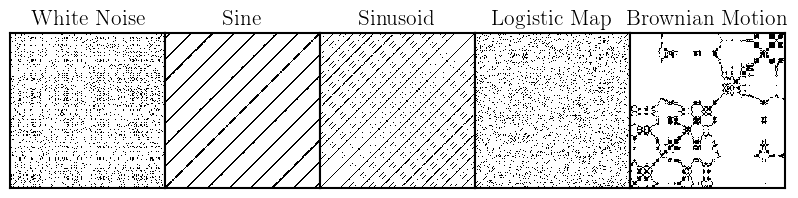

In [11]:
fig, ax = plt.subplots(ncols=5, figsize=(10,5))
fig.subplots_adjust(wspace=0)

systems = [white_noise, sine, super_sine, logi, brownian]
names = ['White Noise', 'Sine', 'Sinusoid', 'Logistic Map', 'Brownian Motion']
for rp, name, axis in zip(systems, names, ax.flatten()):
    axis.matshow(rp, origin='lower', interpolation='none', cmap='Greys')
    axis.tick_params(which="both", axis="both", left=False, top=False, right=False, bottom=False, labelbottom=False, labelleft=False, labeltop=False)
    axis.set_title(name, fontsize=16)
plt.savefig('../plots/characteristic_rps.pdf', bbox_inches='tight')
plt.show()



In [324]:
df = pd.read_csv('/Users/keriheuer/Downloads/1ES_NICER_forKeri.txt', sep='\t')
df = df.sort_values(by='mjd', ascending=True)
df

,mjd,nicer_obsid,phase,lumin,lumin_lowerr,lumin_uperr,kT_bb,kT_bb_lowerr,kT_bb_uperr,gamma,gamma_lowerr,gamma_uperr
0,58261.5947,1.200190e+09,1.0,1.774001e+43,2.616604e+40,2.920340e+41,0.110361,0.000461,0.001146,3.000000,1.600000,7.000000
1,58263.0001,1.200190e+09,1.0,1.216426e+43,9.784894e+40,1.037472e+41,0.104575,0.001489,0.001471,3.000000,1.600000,7.000000
2,58264.6159,1.200190e+09,1.0,3.585650e+42,1.194166e+41,1.078766e+41,0.090196,0.003726,0.003833,3.000000,1.600000,7.000000
3,58265.0020,1.200190e+09,1.0,1.737050e+43,8.606144e+40,1.443835e+41,0.108418,0.002062,0.001965,3.000000,1.600000,7.000000
4,58267.0535,1.200190e+09,1.0,1.006299e+43,8.155711e+40,1.682473e+41,0.101779,0.001353,0.001334,3.000000,1.600000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
427,59380.0322,3.646011e+09,3.0,2.251725e+43,1.273699e+41,1.465027e+41,0.138593,0.002537,0.002538,2.827109,0.033346,0.033081
428,59381.0001,3.646011e+09,3.0,2.095111e+43,2.987811e+41,3.215115e+41,0.149211,0.006276,0.007258,2.994524,0.085268,0.080173
429,59382.0997,3.646011e+09,3.0,2.218006e+43,2.928841e+41,3.058068e+41,0.169548,0.009294,0.011245,3.034858,0.072294,0.068423
430,59383.0038,3.646011e+09,3.0,2.125215e+43,2.490454e+41,2.374154e+41,0.146598,0.006956,0.008075,2.970855,0.063051,0.060158


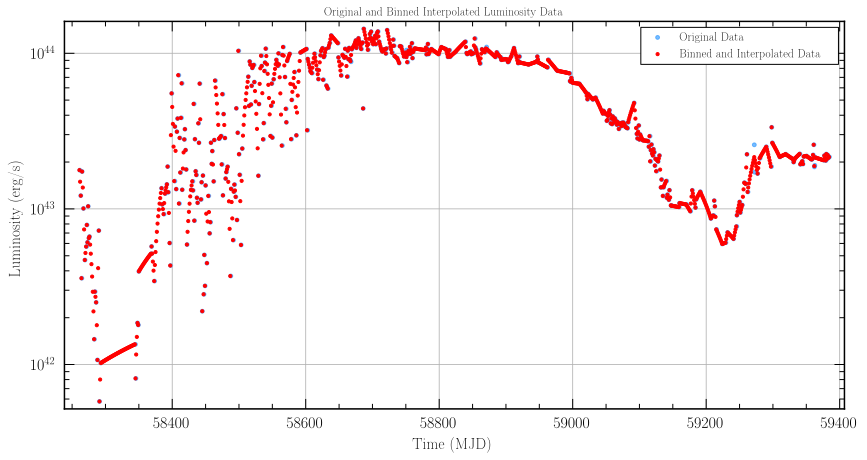

In [4]:
# Define the interpolation function using cubic spline interpolation
from scipy.interpolate import interp1d

time = df['mjd'].values # - df['mjd'].values[0]
luminosity = df['lumin'].values

# daily_time_grid = np.arange(np.round(time[0]), np.round(time[-1]))
daily_time_grid = np.arange(np.floor(time.min()), np.ceil(time.max()) + 1, 1)
binned_df = pd.DataFrame(index=daily_time_grid[:-1])  # Exclude the last edge
binned_df['lumin'] = np.nan

# Aggregate original data into bins by taking the mean for each day
# If multiple measurements fall into one bin, they are averaged
for i, day in enumerate(daily_time_grid[:-1]):
    # Find data points within this day
    daily_data = df[(df['mjd'] >= day) & (df['mjd'] < day + 1)]
    if not daily_data.empty:
        binned_df.loc[day, 'lumin'] = daily_data['lumin'].mean()


# Define the interpolation function using a linear spline ('slinear' in scipy's interp1d)
linear_spline = interp1d(binned_df.dropna().index, binned_df.dropna()['lumin'],
                                           kind='slinear', fill_value='extrapolate')

# Interpolate the luminosity values using the linear spline function at the new time points
interpolated_lumin= linear_spline(daily_time_grid[:-1])

# Update the binned data with the linear spline interpolated values
binned_df['lumin'] = interpolated_lumin

# Plot the original and interpolated data
plt.figure(figsize=(14, 7))
plt.scatter(df['mjd'], df['lumin'], color='dodgerblue', s=15, alpha=0.6, label='Original Data')
plt.scatter(binned_df.index, binned_df['lumin'], color='red', s=10, label='Binned and Interpolated Data', zorder=5)
plt.xlabel('Time (MJD)')
plt.ylabel('Luminosity (erg/s)')
plt.title('Original and Binned Interpolated Luminosity Data')
plt.yscale('log')
plt.legend()
plt.grid(True)


In [114]:
len(df[df['phase'] == 1.0]), len(df[df['phase'] == 2.0]), len(df[df['phase'] == 3.0])
df[df['phase'] == 1.0]['mjd'].values[-1], df[df['phase'] == 2.0]['mjd'].values[-1], df[df['phase'] == 3.0]['mjd'].values[-1]
len(binned_df[binned_df.index < 58679]), len(binned_df[(binned_df.index > 58679) & (binned_df.index < 58898)]), len(binned_df[binned_df.index > 58898])

(418, 218, 486)

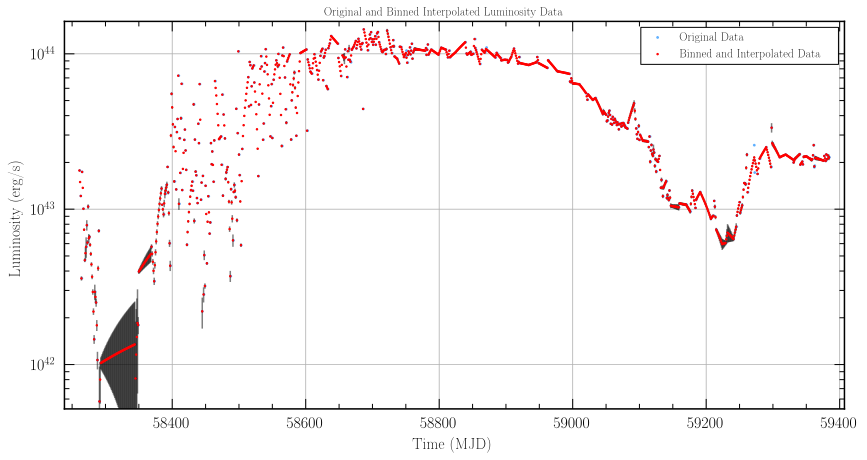

In [328]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

time = df['mjd'].values
luminosity = df['lumin'].values
upper_errors = df['lumin_uperr'].values
lower_errors = df['lumin_lowerr'].values

# Calculate mean error for each point
df['lumin_err'] = (upper_errors + lower_errors) / 2

daily_time_grid = np.arange(np.floor(time.min()), np.ceil(time.max()) + 1, 1)
binned_df = pd.DataFrame(index=daily_time_grid[:-1])  # Exclude the last edge
binned_df['lumin'] = np.nan
binned_df['error'] = np.nan

# Aggregate original data into bins by taking the mean for each day
# If multiple measurements fall into one bin, they are averaged
# Errors are combined using the mean of the upper and lower errors
for i, day in enumerate(daily_time_grid[:-1]):
    # Find data points within this day
    daily_data = df[(df['mjd'] >= day) & (df['mjd'] < day + 1)]
    if not daily_data.empty:
        binned_df.loc[day, 'lumin'] = daily_data['lumin'].mean()
        # Propagate the errors using the mean of upper and lower errors
        binned_df.loc[day, 'error'] = daily_data['lumin_err'].mean()

# Define the interpolation function using a linear spline ('slinear' in scipy's interp1d)
linear_spline = interp1d(binned_df.dropna().index, binned_df.dropna()['lumin'],
                         kind='slinear', fill_value='extrapolate')

# Interpolate the luminosity values using the linear spline function at the new time points
interpolated_lumin = linear_spline(daily_time_grid[:-1])

# Update the binned data with the linear spline interpolated values
binned_df['lumin'] = interpolated_lumin

# Handling error for interpolated points
# Here's a simple approach to interpolate errors linearly, which might not be suitable for all cases
error_spline = interp1d(binned_df.dropna().index, binned_df.dropna()['error'],
                        kind='linear', fill_value='extrapolate')
interpolated_error = error_spline(daily_time_grid[:-1])
binned_df['error'] = interpolated_error


# Plot the original and interpolated data
plt.figure(figsize=(14, 7))
plt.scatter(df['mjd'], df['lumin'], color='dodgerblue', s=15, alpha=0.6, label='Original Data', marker='.')
plt.errorbar(binned_df.index, binned_df['lumin'], yerr=binned_df['error'], color='k', alpha=0.5, marker="", linestyle="", zorder=6)
plt.scatter(binned_df.index, binned_df['lumin'], color='red', s=10, label='Binned and Interpolated Data', zorder=6, marker='.')
plt.xlabel('Time (MJD)')
plt.ylabel('Luminosity (erg/s)')
plt.title('Original and Binned Interpolated Luminosity Data')
plt.yscale('log')
plt.legend()
plt.grid(True)

In [451]:
binned_df2 = binned_df.copy()
binned_df2['mjd'] = binned_df.index

scaled_y, scaled_yerr = scale_lc(binned_df['lumin'].values, binned_df['error'].values)
binned_df2['scaled lumin'] = scaled_y
binned_df2['scaled error'] = scaled_yerr

binned_df2.to_csv('1ES_binned_lc.csv', index=None)

In [ ]:
from pyunicorn.timeseries import RecurrencePlot

ts = binned_df['lumin'].values
ts = (ts - np.mean(ts))/np.std(ts)

fig, ax = plt.subplots() #ncols=2)

rp = RecurrencePlot(data_range['lumin'].values, normalize=True, metric='supremum', local_recurrence_rate=0.05)
ax.matshow(rp.recurrence_matrix(), cmap='Greys', origin='lower', interpolation='none')
plt.savefig('1ES_supremum_localRR_0.05_58300-58700.pdf', bbox_inches='tight')
# rp = RecurrencePlot(ts, normalize=False, metric='manhattan', local_recurrence_rate=0.1)
# ax[1].matshow(rp.recurrence_matrix(), cmap='Greys', origin='lower', interpolation='none')


In [35]:
binned_df['lumin'].to_csv('1ES_lc_binned.csv', index=None)

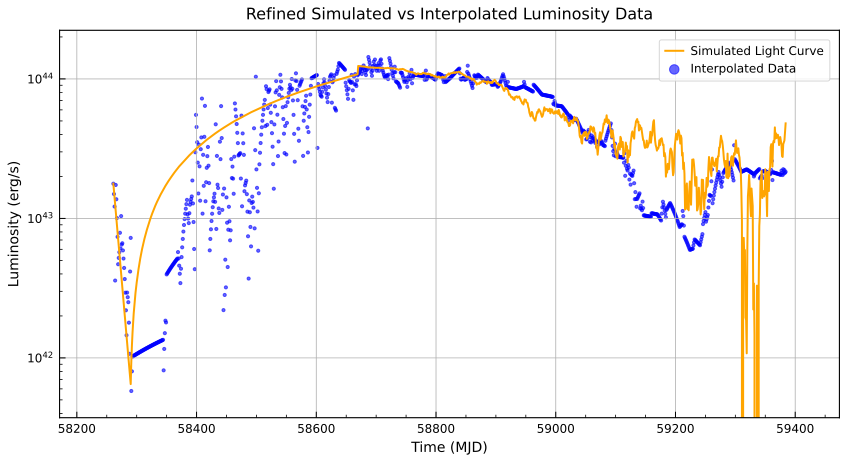

In [187]:
# Adjust the exponential decay to reach 1e42 erg/s
final_value_decay = binned_df['lumin'].min()  # Target final value for the exponential decay
decay_days = 30
decay_start_value = binned_df['lumin'].values[0]
# Find the decay rate that will take us from the initial value to the final value over the decay_days
decay_rate = np.log(final_value_decay / decay_start_value) / decay_days
luminosity_decay = decay_start_value * np.exp(decay_rate * np.arange(decay_days))

# For the rest of the simulation, we need to match the last value of the decay
# Assume that after the decay there's a period of low variability before the light curve starts increasing again.
# Simulate this with a small random walk that starts from the final value of the decay
# and has a small drift upwards to match the variability seen in the data around day 300.
variable_days = 58700 - int(binned_df.index[30])
after_decay_start = luminosity_decay[-1]
after_decay_drift = (binned_df['lumin'].iloc[variable_days] - after_decay_start) / (variable_days - decay_days)
after_decay_noise_level = 1e40  # Assuming a noise level similar to the original data

luminosity_after_decay = np.random.normal(loc=after_decay_drift, scale=after_decay_noise_level, size=(variable_days - decay_days))
luminosity_after_decay = np.cumsum(luminosity_after_decay) + after_decay_start

# Simulate the rest of the light curve using a random walk
# Start this random walk from the value at day 300 and increase the drift and noise level over time
rw_days = len(binned_df) - variable_days
start_value_rw = binned_df['lumin'].iloc[decay_days + variable_days]
end_value_rw = binned_df['lumin'].iloc[-1]
rw_drift = (end_value_rw - start_value_rw) / rw_days
rw_noise_scale = np.linspace(1e40, 5e42, rw_days)  # Gradually increasing the noise level

luminosity_rw = np.random.normal(loc=rw_drift, scale=rw_noise_scale)
luminosity_rw = np.cumsum(luminosity_rw) + start_value_rw

# Combine all segments
simulated_luminosity = np.concatenate((luminosity_decay, luminosity_after_decay, luminosity_rw))
simulated_time = daily_time_grid[:len(simulated_luminosity)]

# Plot the new simulated light curve
plt.figure(figsize=(14, 7))
plt.plot(simulated_time, simulated_luminosity, label='Simulated Light Curve', color='orange', linewidth=2)
plt.scatter(binned_df.index, binned_df['lumin'], color='blue', s=10, label='Interpolated Data', alpha=0.6)
plt.xlabel('Time (MJD)')
plt.ylabel('Luminosity (erg/s)')
plt.title('Refined Simulated vs Interpolated Luminosity Data')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


In [158]:
np.save('1ES_sim_lc2.npy', simulated_luminosity)

# ts = np.load('1ES_sim_lc2.npy')
# ts = (ts - np.mean(ts))/np.std(ts)
# fig, ax = plt.subplots() #ncols=2)
# rp = RecurrencePlot(ts, normalize=False, metric='euclidean', local_recurrence_rate=0.1)
# ax.matshow(rp.recurrence_matrix(), cmap='Greys', origin='lower', interpolation='none')
# plt.savefig('1ES_sim_rp2.png', bbox_inches='tight', dpi=300)


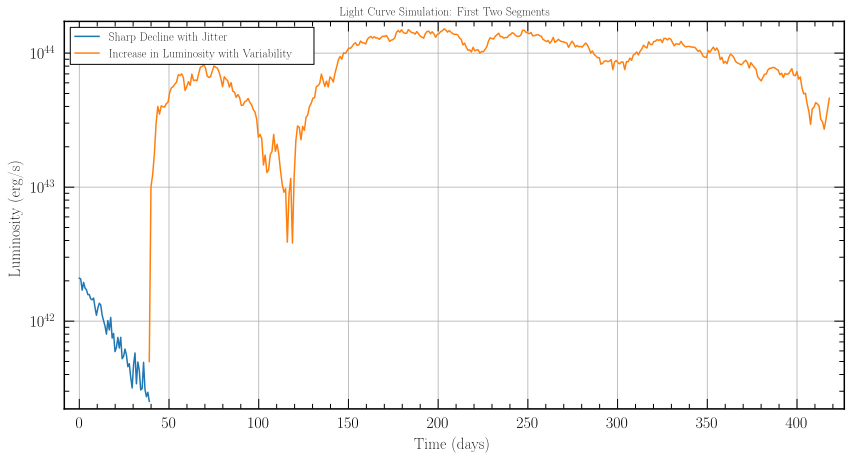

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Segment 1: Sharp Decline with Jitter (Exponential Decay)
def simulate_exponential_decay_with_jitter(t_start, t_end, L0, lambda_decay, jitter_strength, num_points):
    t_decay = np.linspace(t_start, t_end, num_points)
    L_decay = L0 * np.exp(-lambda_decay * (t_decay - t_start))
    jitter = np.random.normal(0, jitter_strength, size=t_decay.shape)
    L_decay_with_jitter = np.clip(L_decay + jitter, a_min=0, a_max=None)
    return t_decay, L_decay_with_jitter

# Segment 2: Increase in Luminosity with Rapid Variability (Random Walk with Drift)
def simulate_random_walk_with_drift(t_start, t_end, initial_luminosity, final_luminosity, variability_scale, num_points):
    t_increase = np.linspace(t_start, t_end, num_points)
    drift_rate = (final_luminosity - initial_luminosity) / (t_end - t_start)
    luminosity_values = np.zeros(num_points)
    luminosity_values[0] = initial_luminosity
    
    np.random.seed(0)  # For reproducibility
    for i in range(1, num_points):
        step = np.random.normal(drift_rate, variability_scale)
        luminosity_values[i] = max(luminosity_values[i - 1] + step, 0)  # Ensure non-negative luminosity
    return t_increase, luminosity_values

# Parameters for the exponential decay
L0 = 2e42  # Initial luminosity
lambda_decay = 0.05  # Decay constant
jitter_strength = 0.05 * L0  # Jitter strength (2% of the initial luminosity)
t_decay_start = 0
t_decay_end = 39
num_points_decay = 50

# Parameters for the random walk with drift
initial_luminosity = 5e41  # Luminosity at the start of the increase
final_luminosity = 1.05e44  # Luminosity at the end of the increase
variability_scale = 0.05 * final_luminosity  # Variability scale
t_increase_start = 39
t_increase_end = 418
num_points_increase = 400 #1000

# Simulate both segments
t_decay, L_decay_with_jitter = simulate_exponential_decay_with_jitter(
    t_decay_start, t_decay_end, L0, lambda_decay, jitter_strength, num_points_decay
)
t_increase, luminosity_increase = simulate_random_walk_with_drift(
    t_increase_start, t_increase_end, initial_luminosity, final_luminosity, variability_scale, num_points_increase
)

# Plotting both segments
plt.figure(figsize=(14, 7))
plt.semilogy(t_decay, L_decay_with_jitter, label='Sharp Decline with Jitter')
plt.semilogy(t_increase, luminosity_increase, label='Increase in Luminosity with Variability')
plt.xlabel('Time (days)')
plt.ylabel('Luminosity (erg/s)')
plt.title('Light Curve Simulation: First Two Segments')
plt.legend()
plt.grid(True)
plt.savefig('1ES_sim_lc_phase1.png', bbox_inches='tight', dpi=300)
plt.show()


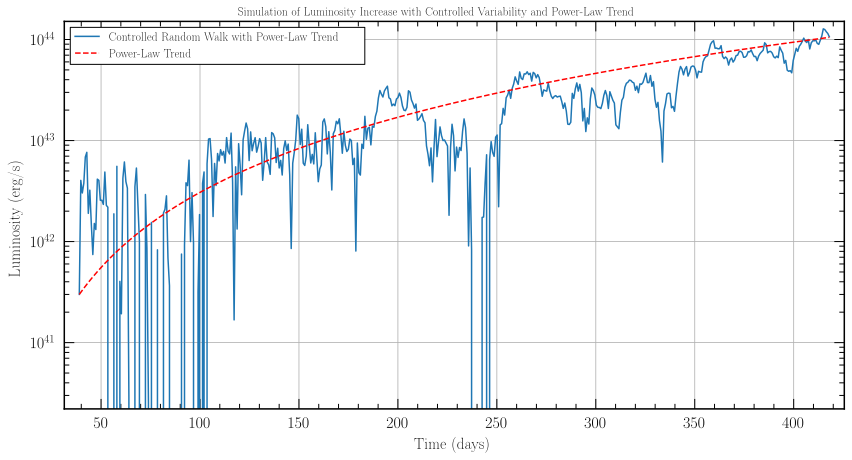

In [66]:
np.random.seed(0)  # Seed for reproducibility
# 
# # Parameters for the random walk with drift
initial_luminosity = 3e41  # Luminosity at the start of the increase
final_luminosity = 1.05e44  # Luminosity at the end of the increase
variability_scale = 0.01 * final_luminosity  # Variability scale
t_increase_start = 39
t_increase_end = 418
num_points_increase = 500 #1000

# Calculate constants a and b for the power-law trend
b = np.log(final_luminosity/initial_luminosity) / np.log(t_increase_end/t_increase_start)
a = initial_luminosity / t_increase_start**b

# Generate time points for the increase segment
t_points_increase = np.linspace(t_increase_start, t_increase_end, num_points_increase)

# Calculate the power-law trend for each time point
power_law_trend = a * t_points_increase**b

# Initialize the array for luminosity values with power-law trend
controlled_luminosity_increase = np.zeros_like(t_points_increase)
controlled_luminosity_increase[0] = initial_luminosity

# Perform the random walk with dynamic mean-reversion based on the power-law trend

# for i in range(1, len(t_points_increase)):
    
    # Parameters for the decreasing variability scale
initial_variability_scale = 0.02 * final_luminosity  # Higher variability at the start
final_variability_scale = 0.07 * final_luminosity   # Lower variability at the end

# Create an array of variability scales that decrease over time
variability_scales = np.linspace(initial_variability_scale, final_variability_scale, num_points_increase)

# Use the new variability scale in the random walk simulation
for i in range(1, len(t_points_increase)):
    # Use the decreasing variability scale
    variability_scale = variability_scales[i]
    variability = np.random.normal(0, variability_scale)

    trend_value = power_law_trend[i]
    deviation_from_trend = controlled_luminosity_increase[i-1] - trend_value
    
    if i < 200:
         mean_reversion_strength = 0.5  
    else:
        mean_reversion_strength = 0.06
    step_size = -deviation_from_trend * mean_reversion_strength
    
    # Update the luminosity value with the step size and variability
    controlled_luminosity_increase[i] = controlled_luminosity_increase[i-1] + step_size + variability

    # Ensure luminosity stays within bounds
    # controlled_luminosity_increase[i] = np.clip(controlled_luminosity_increase[i], initial_luminosity, None)

    # variability = np.random.normal(0, variability_scale)

# Plot the controlled random walk with power-law trend
plt.figure(figsize=(14, 7))
plt.semilogy(t_points_increase, controlled_luminosity_increase, label='Controlled Random Walk with Power-Law Trend')
plt.semilogy(t_points_increase, power_law_trend, label='Power-Law Trend', linestyle='--', color='red')
plt.xlabel('Time (days)')
plt.ylabel('Luminosity (erg/s)')
plt.title('Simulation of Luminosity Increase with Controlled Variability and Power-Law Trend')
plt.legend()
plt.grid(True)
plt.show()


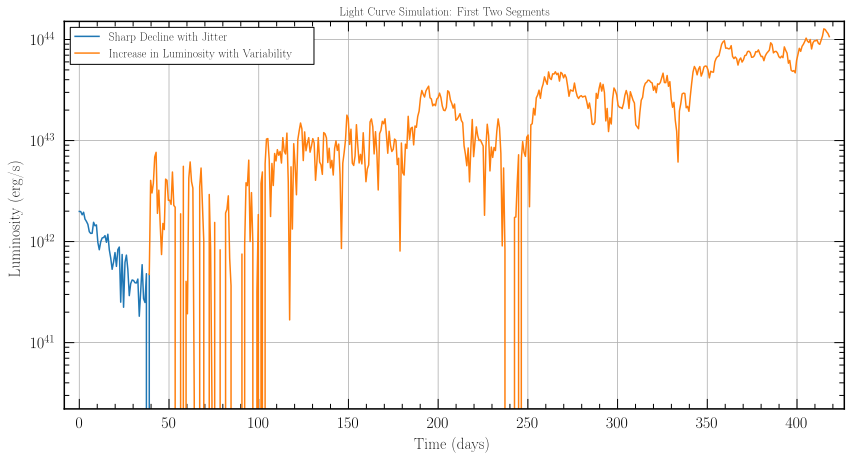

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Segment 1: Sharp Decline with Jitter (Exponential Decay)
def simulate_exponential_decay_with_jitter(t_start, t_end, L0, lambda_decay, jitter_strength, num_points):
    t_decay = np.linspace(t_start, t_end, num_points)
    L_decay = L0 * np.exp(-lambda_decay * (t_decay - t_start))
    jitter = np.random.normal(0, jitter_strength, size=t_decay.shape)
    L_decay_with_jitter = np.clip(L_decay + jitter, a_min=0, a_max=None)
    return t_decay, L_decay_with_jitter

# Segment 2: Increase in Luminosity with Rapid Variability (Random Walk with Drift)
def simulate_random_walk_with_drift(t_start, t_end, initial_luminosity, final_luminosity, variability_scale, num_points):
    t_increase = np.linspace(t_start, t_end, num_points)
    drift_rate = (final_luminosity - initial_luminosity) / (t_end - t_start)
    luminosity_values = np.zeros(num_points)
    luminosity_values[0] = initial_luminosity
    
    np.random.seed(0)  # For reproducibility
    for i in range(1, num_points):
        step = np.random.normal(drift_rate, variability_scale)
        luminosity_values[i] = max(luminosity_values[i - 1] + step, 0)  # Ensure non-negative luminosity
    return t_increase, luminosity_values

# Parameters for the exponential decay
L0 = 2e42  # Initial luminosity
lambda_decay = 0.05  # Decay constant
jitter_strength = 0.08 * L0  # Jitter strength (2% of the initial luminosity)
t_decay_start = 0
t_decay_end = 39
num_points_decay = 50

# Parameters for the random walk with drift
initial_luminosity = 5e41  # Luminosity at the start of the increase
final_luminosity = 1.05e44  # Luminosity at the end of the increase
variability_scale = 0.05 * final_luminosity  # Variability scale
t_increase_start = 39
t_increase_end = 418
num_points_increase = 400 #1000

# Simulate both segments
t_decay, L_decay_with_jitter = simulate_exponential_decay_with_jitter(
    t_decay_start, t_decay_end, L0, lambda_decay, jitter_strength, num_points_decay
)
t_increase, luminosity_increase = simulate_random_walk_with_drift(
    t_increase_start, t_increase_end, initial_luminosity, final_luminosity, variability_scale, num_points_increase
)

# connect phase 2 with phase 1
controlled_luminosity_increase[0] = L_decay_with_jitter[-1]

# Plotting both segments
plt.figure(figsize=(14, 7))
plt.semilogy(t_decay, L_decay_with_jitter, label='Sharp Decline with Jitter')
plt.semilogy(t_points_increase, controlled_luminosity_increase, label='Increase in Luminosity with Variability')
plt.xlabel('Time (days)')
plt.ylabel('Luminosity (erg/s)')
plt.title('Light Curve Simulation: First Two Segments')
plt.legend()
plt.grid(True)
plt.savefig('1ES_sim_lc_phase1.png', bbox_inches='tight', dpi=300)
plt.show()

# this one is closest simulation of Phase 1 and 2 

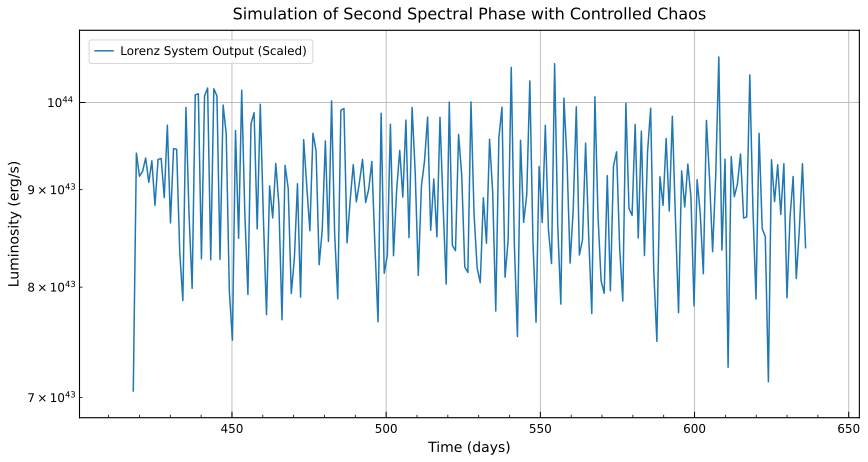

In [317]:
from scipy.integrate import solve_ivp

# Define the Lorenz system differential equations
def lorenz_system(t, state, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Lorenz system parameters for controlled chaos
sigma = 10.0  # Lorenz system parameter
rho = 28.0    # Lorenz system parameter (lower this for less intense chaos)
beta = 2.667  # Lorenz system parameter

# Initial state for the Lorenz system
initial_state_lorenz = [1.0, 1.0, 1.0]

# Time points for the second spectral phase
t_lorenz_start = 418
t_lorenz_end = 636
t_points_lorenz = np.linspace(t_lorenz_start, t_lorenz_end, t_lorenz_end - t_lorenz_start)

# Integrate the Lorenz system over the second spectral phase
solution_lorenz = solve_ivp(
    lorenz_system,
    [t_points_lorenz[0], t_points_lorenz[-1]],
    initial_state_lorenz,
    args=(sigma, rho, beta),
    t_eval=t_points_lorenz,
    method='RK45'
)

# Scale the Lorenz system output to the observed luminosity range
z_lorenz = solution_lorenz.y[2]
min_luminosity_phase2 = 7e43  # 
max_luminosity_phase2 = 1.05e44  
z_lorenz_scaled = np.interp(z_lorenz, (np.min(z_lorenz), np.max(z_lorenz)), (min_luminosity_phase2, max_luminosity_phase2))

# Add a small amount of noise to the scaled Lorenz output
noise_level_phase2 = 0.01 * max_luminosity_phase2
z_lorenz_scaled_with_noise = z_lorenz_scaled + np.random.normal(0, noise_level_phase2, z_lorenz_scaled.shape)

# Plot the Lorenz system output for the second spectral phase
plt.figure(figsize=(14, 7))
plt.semilogy(t_points_lorenz, z_lorenz_scaled_with_noise, label='Lorenz System Output (Scaled)')
plt.xlabel('Time (days)')
plt.ylabel('Luminosity (erg/s)')
plt.title('Simulation of Second Spectral Phase with Controlled Chaos')
plt.legend()
plt.grid(True)
plt.show()


TO DO: To determine whether the end of the RP is indicative of regular Brownian motion, fractal behavior, or disrupted/damped motion, try to analyze the statistical properties of the RP, such as the distribution of recurrence times or the scaling properties of the fluctuations. Regular Brownian motion would have a certain characteristic scaling, while damped motion would show a decline in the amplitude of fluctuations over time.

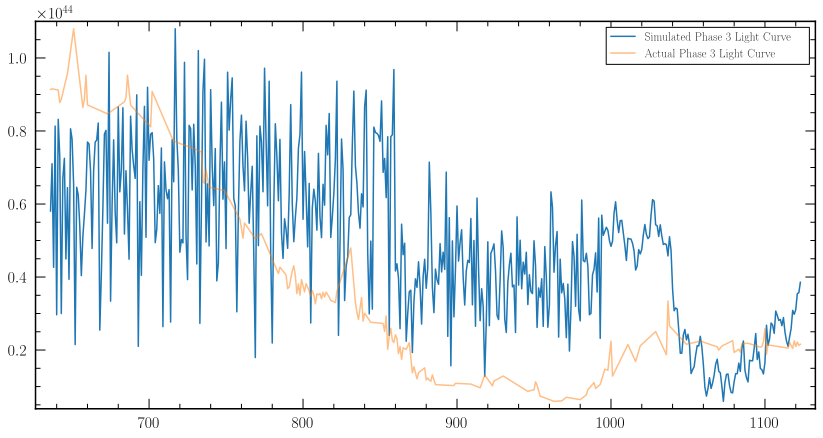

In [315]:
import numpy as np

phase3 = binned_df['lumin'].values[636:]

def simulate_phase_3(phase3_start, phase3_end, actual_data, decay_length, middle_length, noise_scale_decay, noise_scale_middle, noise_scale_brownian):
    # Initialize the simulated light curve with zeros
    simulated_light_curve = np.zeros(phase3_end - phase3_start)
    
    # Decay Segment: Negative log-like decay with fluctuations
    decay = -np.log(np.linspace(1, np.e, decay_length)) / 5  # Scale down the log function
    decay += np.random.normal(0, noise_scale_decay, decay_length)  # Add noise
    simulated_light_curve[:decay_length] = decay
    
    # Middle Segment: Upward trend with variability
    middle_start = simulated_light_curve[decay_length-1]
    middle_trend = np.linspace(middle_start, middle_start * 1.2, middle_length)  # Linear trend
    middle = middle_trend + np.random.normal(0, noise_scale_middle, middle_length)  # Add noise
    simulated_light_curve[decay_length:decay_length+middle_length] = middle
    
    # Final Segment: Transition to regular Brownian motion
    brownian_start = simulated_light_curve[decay_length+middle_length-1]
    brownian_length = phase3_end - phase3_start - decay_length - middle_length
    brownian_motion = np.cumsum(np.random.normal(0, noise_scale_brownian, brownian_length)) + brownian_start
    simulated_light_curve[decay_length+middle_length:] = brownian_motion
    
    # Normalize the simulated curve to the same scale as the actual data
    min_actual = np.min(actual_data[phase3_start:phase3_end])
    max_actual = np.max(actual_data[phase3_start:phase3_end])
    simulated_light_curve = np.interp(simulated_light_curve, (np.min(simulated_light_curve), np.max(simulated_light_curve)), (min_actual, max_actual))
    
    return simulated_light_curve

actual_data = binned_df['lumin'].values

# Parameters for the simulation
phase3_start = 636
phase3_end = len(actual_data)
decay_length = 225
middle_length = 135
noise_scale_decay = 0.05 * (np.max(actual_data) - np.min(actual_data))
noise_scale_middle = 0.03 * (np.max(actual_data) - np.min(actual_data))
noise_scale_brownian = 0.01 * (np.max(actual_data) - np.min(actual_data))

# Simulate Phase 3
phase3_simulation = simulate_phase_3(phase3_start, phase3_end, actual_data, decay_length, middle_length, noise_scale_decay, noise_scale_middle, noise_scale_brownian)

# Plot the simulated Phase 3 light curve
plt.figure(figsize=(14, 7))
plt.plot(np.arange(phase3_start, phase3_end), phase3_simulation, label='Simulated Phase 3 Light Curve')
plt.plot(np.arange(phase3_start, phase3_end), actual_data[phase3_start:phase3_end], label='Actual Phase 3 Light Curve', alpha=0.5)
plt.legend()
plt.show()

# close-ish


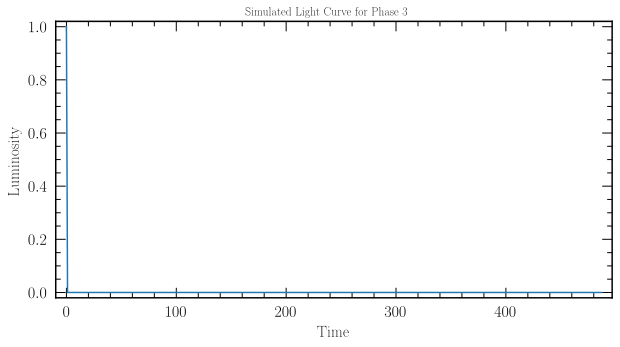

In [322]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_phase_3(start_index, end_index, dataset):
    # Parameters for the three segments
    # These parameters need to be fine-tuned to match the observed light curve
    params = [
        {"omega": 0.1, "zeta": 0.05, "A": 1.0},  # Parameters for the first segment
        {"omega": 0.2, "zeta": 0.1, "A": 0.8},   # Parameters for the second segment
        {"omega": 0.05, "zeta": 0.2, "A": 0.6}   # Parameters for the third segment
    ]
    
    # Lengths of the segments
    lengths = [225, 135, end_index - start_index - 225 - 135]
    
    # Time vector for the simulation
    t = np.arange(0, end_index - start_index, 1)
    
    # The resulting light curve
    light_curve = np.zeros_like(t)
    
    # Current index in the light curve
    current_index = 0
    
    # Simulate each segment
    for i, length in enumerate(lengths):
        # Extract parameters for the current segment
        omega = params[i]["omega"]
        zeta = params[i]["zeta"]
        A = params[i]["A"]
        
        # Time vector for the current segment
        t_segment = t[current_index:current_index+length]
        
        # Damped harmonic oscillator model for the current segment
        x = A * np.exp(-zeta * omega * t_segment) * np.cos(omega * t_segment)
        
        # Add the current segment to the light curve
        light_curve[current_index:current_index+length] = x
        
        # Update the current index
        current_index += length
    
    return light_curve

# Start and end indices for Phase 3
start_index = 636
end_index = len(binned_df)  # Replace with the actual length of Phase 3 in your dataset

# Simulate Phase 3
simulated_light_curve = simulate_phase_3(start_index, end_index, binned_df['lumin'].values)

# Plot the simulated light curve
plt.plot(simulated_light_curve)
plt.xlabel('Time')
plt.ylabel('Luminosity')
plt.title('Simulated Light Curve for Phase 3')
plt.show()


In [320]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_dho_decay(length, damping_factor, frequency, amplitude, noise_scale):
    t = np.linspace(0, length, length)
    decay = amplitude * np.exp(-damping_factor * t) * np.cos(2 * np.pi * frequency * t)
    noise = noise_scale * np.random.randn(length)
    return decay + noise

def simulate_recovery_with_drift(length, initial_value, drift_rate, noise_scale):
    drift = initial_value + drift_rate * np.arange(length)
    noise = noise_scale * np.random.randn(length)
    return drift + noise

def simulate_brownian_motion(length, noise_scale):
    return np.cumsum(noise_scale * np.random.randn(length))

def determine_lengths(total_length, decay_length, recovery_length):
    brownian_length = total_length - decay_length - recovery_length
    return decay_length, recovery_length, brownian_length

def simulate_phase_3_combined(total_length, decay_length, recovery_length, decay_params, recovery_params, brownian_params):
    decay_length, recovery_length, brownian_length = determine_lengths(total_length, decay_length, recovery_length)
    
    # Simulate the decay segment
    decay_segment = simulate_dho_decay(decay_length, **decay_params)
    
    # Update the initial value in recovery_params based on the last value of the decay segment
    recovery_params['initial_value'] = decay_segment[-1]
    
    # Simulate the recovery segment
    recovery_segment = simulate_recovery_with_drift(recovery_length, **recovery_params)
    
    # Simulate the Brownian motion segment starting from where recovery ended
    brownian_params['initial_value'] = recovery_segment[-1] 
    brownian_segment = simulate_brownian_motion(brownian_length, **brownian_params)
    
    # Concatenate all segments
    combined_curve = np.concatenate([decay_segment, recovery_segment, brownian_segment])
    
    return combined_curve

# Define parameters based on the characteristics observed in actual data
decay_params = {
    'damping_factor': 0.01,  # set based on observed decay behavior
    'frequency': 0.05,       # set based on observed fluctuation frequency
    'amplitude': 1.0,        # set based on observed fluctuation amplitude
    'noise_scale': 0.05,     # set based on actual data noise level
}
recovery_params = {
    'initial_value': 0.5,    # set to the last value of the decay segment
    'drift_rate': 0.005,     # set based on observed recovery trend
    'noise_scale': 0.05,     # set based on actual data noise level
}
brownian_params = {
    'noise_scale': 0.02,     # set based on actual data noise level in the constant segment
}

total_length = len(phase3) 
decay_length = 225   #approximate decay length
recovery_length = 168  # approximate recovery length

simulated_phase_3 = simulate_phase_3_combined(total_length, decay_length, recovery_length, decay_params, recovery_params, brownian_params)

# Plot the simulated light curve
plt.figure(figsize=(14, 7))
plt.plot(simulated_phase_3, label='Simulated Phase 3 Light Curve')
plt.legend()
plt.show()


TypeError: simulate_brownian_motion() got an unexpected keyword argument 'initial_value'

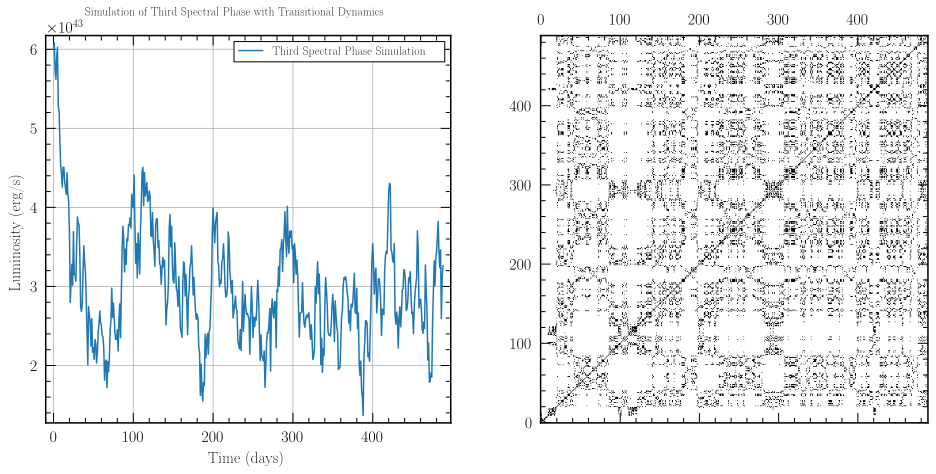

In [316]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the Ornstein-Uhlenbeck process
def ornstein_uhlenbeck(t, x, theta, mu, sigma):
    return theta * (mu - x)

# Parameters for the third spectral phase
initial_luminosity_third_phase = 6e43  # Starting luminosity (end of second phase)
theta = 0.15  # Rate of mean reversion for the OU process
mu = 3e43     # Long-term mean for the OU process
sigma_ou = 0.1 * mu  # Volatility parameter for the OU process
dt = 1        # Time increment for the OU process

# Time points for the third spectral phase
t_third_phase_start = 0 #636
t_third_phase_end = len(phase3) 
t_points_third_phase = np.linspace(t_third_phase_start, t_third_phase_end, t_third_phase_end - t_third_phase_start + 1)

# Initialize the luminosity array
luminosity_third_phase = np.zeros_like(t_points_third_phase)
luminosity_third_phase[0] = initial_luminosity_third_phase

# Simulate Ornstein-Uhlenbeck process
np.random.seed(0)  # Seed for reproducibility
for i in range(1, len(t_points_third_phase)):
    # Calculate the OU step
    ou_step = theta * (mu - luminosity_third_phase[i-1]) * dt
    ou_step += sigma_ou * np.sqrt(dt) * np.random.normal()
    
    # Update the luminosity value with the OU step
    luminosity_third_phase[i] = luminosity_third_phase[i-1] + ou_step

# Plot the third spectral phase
fig, (ax, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
ax.plot(t_points_third_phase, luminosity_third_phase, label='Third Spectral Phase Simulation')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Luminosity (erg/s)')
ax.set_title('Simulation of Third Spectral Phase with Transitional Dynamics')
ax.legend()
ax.grid(True)
from pyunicorn.timeseries import RecurrencePlot
rp = RecurrencePlot(np.log10(luminosity_third_phase), metric='euclidean', recurrence_rate=0.1, silence_level=2)
ax2.matshow(rp.recurrence_matrix(), origin='lower', interpolation='none', cmap='Greys')
plt.show()


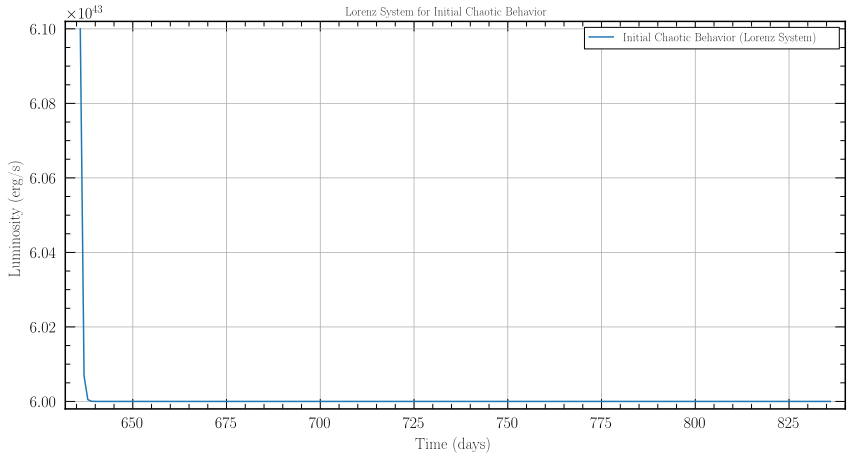

In [78]:
# Lorenz system differential equations
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Lorenz system parameters for controlled chaos
sigma = 10.0  # Parameter sigma
beta = 8/3    # Parameter beta
rho = 28.0    # Parameter rho 

# Initial conditions for the Lorenz system
# Assuming the chaotic behavior continues from where the second phase ended
initial_x = 0.0
initial_y = 0.0
initial_z = 6e43  # This should be the final luminosity value from the second phase

# Time points for the initial chaotic behavior
t_chaos_start = 636  # day 636 is where the second phase ends
t_chaos_end = 836   
t_points_chaos = np.linspace(t_chaos_start, t_chaos_end, int(t_chaos_end - t_chaos_start))

# Integrate the Lorenz system
solution = solve_ivp(
    lorenz,
    (t_points_chaos[0], t_points_chaos[-1]),
    [initial_x, initial_y, initial_z],
    args=(sigma, beta, rho),
    t_eval=t_points_chaos,
    dense_output=True
)

# Scale the Lorenz system output
# set the amplitude of the chaotic behavior to be small
scale_factor = 1e42  # scale the Lorenz system's z-component to the same order of magnitude as data
z_scaled = solution.y[2] / np.max(np.abs(solution.y[2])) * scale_factor + initial_z

# Plot the initial chaotic behavior
plt.figure(figsize=(14, 7))
plt.plot(t_points_chaos, z_scaled, label='Initial Chaotic Behavior (Lorenz System)')
plt.xlabel('Time (days)')
plt.ylabel('Luminosity (erg/s)')
plt.title('Lorenz System for Initial Chaotic Behavior')
plt.legend()
plt.grid(True)
plt.show()


In [96]:
import numpy as np
from eztao.carma import DHO_term
from eztao.ts import gpSimRand
from eztao.ts import carma_fit

# define a DHO kernel
dho_kernel = DHO_term(np.log(0.04), np.log(0.0027941), np.log(0.004672),
                      np.log(0.0257))

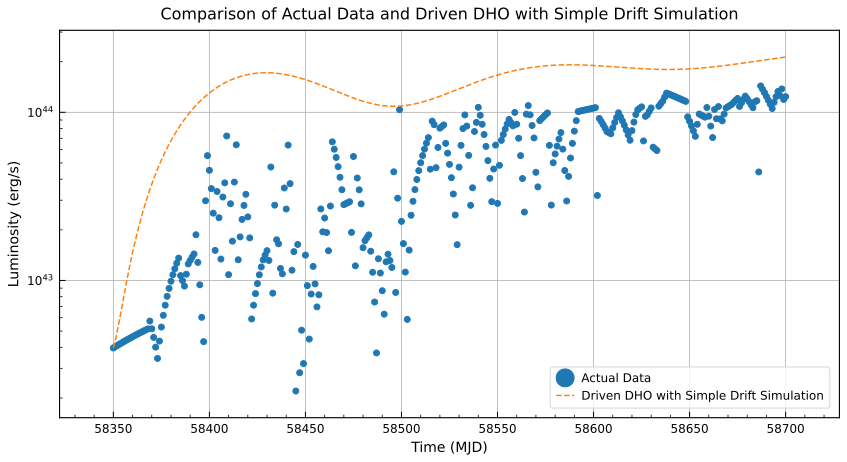

In [106]:
data_range = binned_df[(binned_df.index >= 58350) & (binned_df.index <=58700)]

# driven Damped Harmonic Oscillator (DHO) differential equations with a simple driving force
def driven_damped_harmonic_oscillator_simple(t, state, omega_0, zeta, driving_amplitude):
    x, v = state  # Position (x) and velocity (v)
    dxdt = v
    # use constant amplitude as driving force
    driving_force = driving_amplitude
    dvdt = -2 * zeta * omega_0 * v - omega_0**2 * x + driving_force
    return [dxdt, dvdt]

# Set initial parameters for the DHO
omega_0_dho_simple = 2 * np.pi / 150  # Natural frequency (adjusted for a longer period)
zeta_dho_simple = 0.15  # Damping ratio (adjusted for a slower rise)
driving_amplitude_dho_simple = 0.1  # Amplitude of simple driving force
initial_state_dho_simple = [0, 0]  # Initial position and velocity

# Time points for integration
t_points_simple = data_range.index

# Integrate the driven DHO equations with the simple driving force over time
solution_driven_dho_simple = solve_ivp(
    driven_damped_harmonic_oscillator_simple,
    [t_points_simple[0], t_points_simple[-1]],
    initial_state_dho_simple,
    args=(omega_0_dho_simple, zeta_dho_simple, driving_amplitude_dho_simple),
    t_eval=t_points_simple,
    method='RK45'
)

# Get the position (x-component) of the solution 
x_driven_dho_simple = solution_driven_dho_simple.y[0]

# Scale driven DHO output to match the luminosity range and add drift term to model increasing luminosity
x_driven_dho_simple_scaled = np.interp(x_driven_dho_simple, (np.min(x_driven_dho_simple), np.max(x_driven_dho_simple)), (np.min(data_range['lumin']), np.max(data_range['lumin'])))
positive_drift_driven_dho_simple = np.mean(np.diff(data_range['lumin']))  # Apply a drift based on the average change in luminosity
x_driven_dho_simple_with_drift = x_driven_dho_simple_scaled + np.arange(len(x_driven_dho_simple_scaled)) * positive_drift_driven_dho_simple

# Make sure the driven DHO model starts at initial luminosity value
initial_luminosity = data_range['lumin'].iloc[0] 
x_driven_dho_simple_with_drift = initial_luminosity + (x_driven_dho_simple_with_drift - x_driven_dho_simple_with_drift[0])

# Plot the actual data and the driven DHO simulation with the simple driving force
plt.figure(figsize=(14, 7))
plt.plot(data_range.index, data_range['lumin'], 'o', label='Actual Data')
plt.plot(t_points_simple, x_driven_dho_simple_with_drift, label='Driven DHO with Simple Drift Simulation', linestyle='--')
plt.xlabel('Time (MJD)')
plt.ylabel('Luminosity (erg/s)')
plt.yscale('log')
plt.title('Comparison of Actual Data and Driven DHO with Simple Drift Simulation')
plt.legend()
plt.grid(True)
plt.show()



In [384]:
def scale_lc(luminosity, errors, method='fraction_of_max'):
    """
    Scale the luminosity and errors.

    Args:
    - luminosity (array-like): Luminosity values.
    - errors (array-like): Corresponding errors for the luminosity values.
    - method (str): Method to scale the luminosity and errors ('fraction_of_max', 'z_score', 'logarithmic').

    Returns:
    - scaled_luminosity (np.ndarray): Scaled luminosity.
    - scaled_errors (np.ndarray): Scaled errors.
    """
    
    if method == 'fraction_of_max':
        # Scale by the maximum luminosity value
        max_lumin = np.max(luminosity)
        scaled_luminosity = luminosity / max_lumin
        scaled_errors = errors / max_lumin  # Scale errors in the same way as luminosity
        
    elif method == 'z_score':
        # Scale by z-score (mean=0, std=1)
        mean_lumin = np.mean(luminosity)
        std_lumin = np.std(luminosity)
        scaled_luminosity = (luminosity - mean_lumin) / std_lumin
        scaled_errors = errors / std_lumin  # Errors are scaled by the std of the luminosity
        
    elif method == 'logarithmic':
        # Apply logarithmic scaling
        scaled_luminosity = np.log10(luminosity)
        # Scale errors using logarithmic error propagation rule
        scaled_errors = errors / (luminosity * np.log(10))
        
    else:
        raise ValueError("Invalid method. Use 'fraction_of_max', 'z_score', or 'logarithmic'.")
    
    return scaled_luminosity, scaled_errors

def unscale_lc(scaled_luminosity, scaled_errors, original_params, method='fraction_of_max'):
    """
    Reverse the scaling applied to luminosity and errors.

    Args:
    - scaled_luminosity (np.ndarray): Scaled luminosity values.
    - scaled_errors (np.ndarray): Scaled errors corresponding to the luminosity values.
    - original_params (dict): Parameters used for the original scaling, like 'mean', 'std', and 'max_lumin'.
    - method (str): Method that was used to scale the luminosity and errors ('fraction_of_max', 'z_score', 'logarithmic').

    Returns:
    - original_luminosity (np.ndarray): Luminosity values in original scale.
    - original_errors (np.ndarray): Errors in original scale.
    """
    
    if method == 'fraction_of_max':
        max_lumin = original_params['max_lumin']
        original_luminosity = scaled_luminosity * max_lumin
        original_errors = scaled_errors * max_lumin
        
    elif method == 'z_score':
        mean_lumin = original_params['mean']
        std_lumin = original_params['std']
        original_luminosity = scaled_luminosity * std_lumin + mean_lumin
        original_errors = scaled_errors * std_lumin
        
    elif method == 'logarithmic':
        original_luminosity = 10 ** scaled_luminosity
        # Inverse of the logarithmic error propagation
        original_errors = scaled_errors * (10 ** scaled_luminosity * np.log(10))
        
    else:
        raise ValueError("Invalid method. Use 'fraction_of_max', 'z_score', or 'logarithmic'.")
    
    return original_luminosity, original_errors


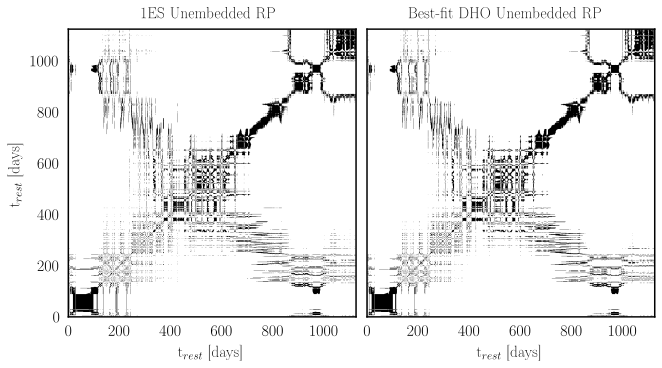

In [388]:

fig, (ax, ax2) = plt.subplots(figsize=(10,5), ncols=2, layout='compressed')
rp = RecurrencePlot(y_orig, metric='supremum', silence_level=2, local_recurrence_rate=0.08)
pred_rp = RecurrencePlot(mu, metric='supremum', silence_level=2, local_recurrence_rate=0.08)
ax.matshow(rp.recurrence_matrix(), origin='lower', interpolation='none', cmap='Greys')
ax2.matshow(pred_rp.recurrence_matrix(), origin='lower', interpolation='none', cmap='Greys')
for axis in (ax, ax2):
    axis.set_xlabel(r't$_{rest}$ [days]')
ax.tick_params(which="both", axis="both", labeltop=False, labelbottom=True, top=False, left=False, bottom=False)
ax2.tick_params(which="both", axis="both", labeltop=False, labelbottom=True, top=False, left=False, bottom=False, labelleft=False)
# axis.tick_params(which="both", axis="both", left=False, top=False, right=False, bottom=False, labelbottom=False, labelleft=False, labeltop=False)
ax.set_ylabel(r't$_{rest}$ [days]')
ax.set_title('1ES Unembedded RP')
ax2.set_title('Best-fit DHO Unembedded RP')
fig.savefig('../plots/1ES_RP_compare_DHO_RP_orig.pdf', bbox_inches='tight')
plt.show()

In [472]:
# binned_df['time'] = binned_df.index - binned_df.index.min()
binned_df2['scaled lumin'] = y
binned_df2['scaled error'] = yerr
binned_df2.to_csv('1ES_binned_lc.csv', index=None)
binned_df2


,lumin,error,time,mjd,scaled lumin,scaled error
58261.0,1.774001e+43,1.591000e+41,0.0,58261.0,-0.837798,0.003905
58262.0,1.495214e+43,1.299490e+41,1.0,58262.0,-0.906220,0.003189
58263.0,1.216426e+43,1.007981e+41,2.0,58263.0,-0.974641,0.002474
58264.0,3.585650e+42,1.136466e+41,3.0,58264.0,-1.185181,0.002789
58265.0,1.737050e+43,1.152225e+41,4.0,58265.0,-0.846867,0.002828
...,...,...,...,...,...,...
59380.0,2.251725e+43,1.369363e+41,1119.0,59380.0,-0.720554,0.003361
59381.0,2.095111e+43,3.101463e+41,1120.0,59381.0,-0.758991,0.007612
59382.0,2.218006e+43,2.993454e+41,1121.0,59382.0,-0.728829,0.007347
59383.0,2.125215e+43,2.432304e+41,1122.0,59383.0,-0.751602,0.005969


In [471]:

# Define the mapping for whether larger values of the metric indicate stronger network structure
larger_is_better_mapping = {
    # Recurrence rate is the fraction of points in the phase space that are recurrent
    # A higher value indicates more recurrent behavior, which could suggest more stable periodicity or constant dynamics
    # 'recurrence_rate': True,  
    
    # Determinism is the fraction of recurrence points forming diagonal lines
    # Higher determinism implies more predictable and less chaotic behavior
    'determinism': True,     
    
    # The average length of the diagonal lines in the RP, excluding single point 
    # Longer lines suggest more predictability and stability in the dynamics
    'average_diagonal_line_length': True,   
    
    # The length of the longest diagonal line, which can be interpreted as the longest period of predictable behavior
    'longest_diagonal_line': True,  
    
    # Entropy of the diagonal line lengths. Higher entropy suggests more complexity and richness in the dynamics
    'entropy_diagonal_lines': True,  
    
    # Laminarity or verticality is the fraction of points forming vertical lines
    # Higher laminarity can indicate trapped states or longer periods where the system's state is unchanged
    'laminarity': True,  
    
    # Trapping time is the average length of vertical lines
    # It represents the average time that the trajectory stays in the vicinity of a state, so higher values suggest more stable states
    'trapping_time': True,  
    
    # The average length of vertical lines in the RP, indicating the time the system stays close to a state
    'average_vertical_line_length': True,  
    
    # The length of the longest vertical line, indicating the longest time the system stays close to a state
    'longest_vertical_line': True,  
    
    # Entropy of the vertical line lengths, representing the complexity in the times the system is in a particular state
    'entropy_vertical_lines': True
}


# Compute the p-values DataFrame
p_values_df = compute_p_values(original_rqa_df, rqa_df)
print(p_values_df)

array([-0.83779848, -0.90621972, -0.97464095, -1.18518062, -0.84686735,
       -0.93653927, -1.0262112 , -1.09210365, -1.1579961 , -1.14533141])

Error: must supply twinxlabel if twinx supplied, not plotting twinx.


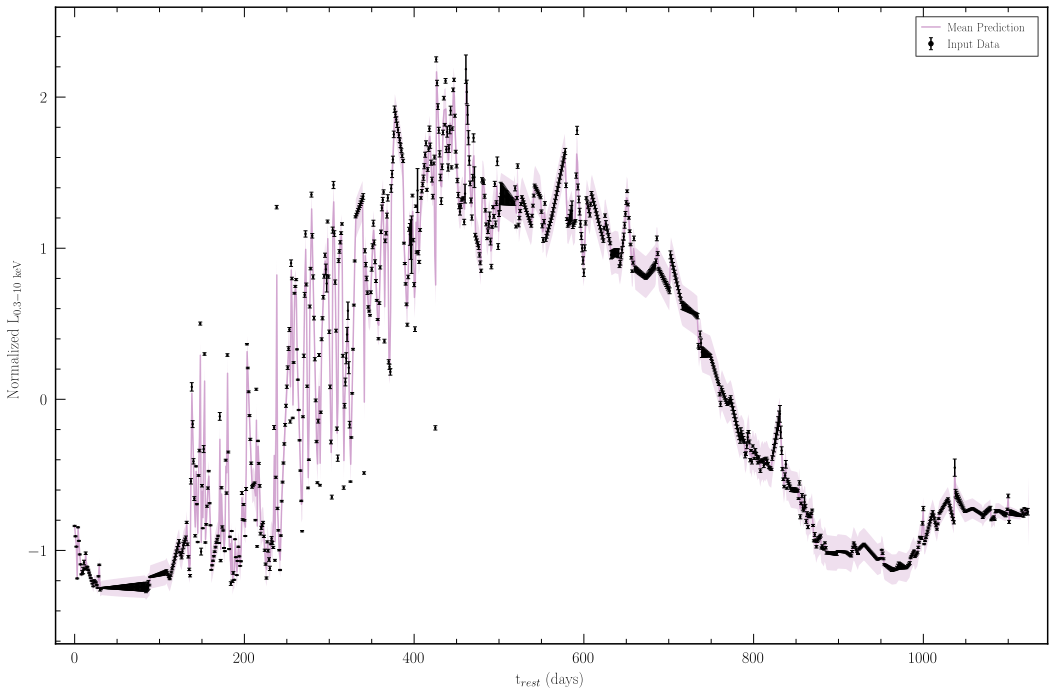

In [466]:
# try to fit light curve with eztao 
plt.style.use('../standard.mplstyle')
from eztao.ts import dho_fit, carma_fit
from eztao.viz import plot_pred_lc
from eztao.carma import DHO_term

# fit
p = 2
q = 1

# best_fit = carma_fit(t, y, yerr, p, q, n_opt=10)
best_fit = dho_fit(t, y, yerr, n_opt=10)

# get best-fit in CARMA space
best_fit_kernel = DHO_term(*np.log(best_fit))

# Example scaling parameters from the original scaling
original_params = {
    'mean': binned_df['lumin'].mean(), 
    'std': binned_df['lumin'].std(), 
    'max_lumin': binned_df['lumin'].max()
}

t_pred = np.linspace(0, len(t), len(binned_df))
# L$_{0.3-10\mathrm{keV}}$ (erg/s)'
fig, mu, var = plot_predicted_lc(t, y, yerr, best_fit, 2, t_pred, ylabel=r'Normalized L$_{0.3-10\ \mathrm{keV}}$') #, original_params=original_params) #, twinx=binned_df.index.values, twinxlabel='MJD (days)')
# fig.savefig('../plots/1ES_pred_DHO_lc_full.pdf', bbox_inches='tight')

# plot predicted lightcurve at original time points
# from rqa_utils import plot_predicted_lc
# t_orig = df['mjd'].values - df['mjd'].min()
# y_orig, yerr_orig = scale_lc(df['lumin'].values, df['lumin_err'].values, method='z_score')
    # get pred lc

# fig, t_pred, mu, var = plot_predicted_lc(t_orig, y_orig, yerr_orig, best_fit, 2, t_orig, ylabel=r'Normalized L$_{0.3-10\ \mathrm{keV}}$') #, original_params=original_params) #, twinx=binned_df.index.values, twinxlabel='MJD (days)')
# fig.savefig('../plots/1ES_pred_DHO_lc_orig.pdf', bbox_inches='tight')

In [468]:
# pred_t, mu, var = pred_lc(t, y, yerr, best_fit, 2, t)

pred_df = pd.DataFrame([(x,y,z) for x,y,z in zip(t_pred, mu, var)], columns=['time', 'lumin', 'error'])

pred_scaled_y, pred_scaled_yerr = scale_lc(pred_df['lumin'].values, pred_df['error'].values)
pred_df['mjd'] = binned_df.index.values
# pred_df['scaled lumin'] = pred_scaled_y
# pred_df['scaled error'] = pred_scaled_yerr

pred_df.to_csv('1ES_pred_DHO_lc.csv', index=None)

# pred_df_orig = pd.DataFrame([(x,y,z) for x,y,z in zip(t_pred, mu, var)], columns=['pred_t', 'pred_lumin', 'pred_err'])
# pred_df_orig.to_csv('1ES_pred_DHO_lc_orig.csv', index=None)
pred_df

,time,lumin,error,mjd
0,0.000000,-0.837798,-4.440892e-16,58261.0
1,1.000890,-0.906294,7.337698e-05,58262.0
2,2.001781,-0.975012,1.466097e-04,58263.0
3,3.002671,-1.184261,2.196980e-04,58264.0
4,4.003562,-0.847282,2.926420e-04,58265.0
...,...,...,...,...
1119,1119.996438,-0.758854,2.926423e-04,59380.0
1120,1120.997329,-0.728913,2.196982e-04,59381.0
1121,1121.998219,-0.751562,1.466098e-04,59382.0
1122,1122.999110,-0.743725,7.337701e-05,59383.0


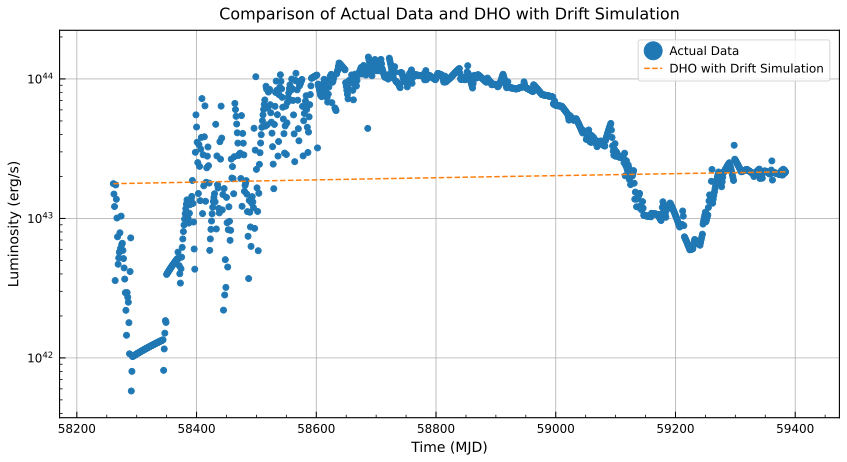

In [89]:
# Define DHO differential equations
def damped_harmonic_oscillator(t, state, omega_0, zeta):
    x, v = state  # Position (x) and velocity (v)
    dxdt = v
    dvdt = -2 * zeta * omega_0 * v - omega_0**2 * x
    return [dxdt, dvdt]

# Set initial parameters for the DHO
omega_0_dho = 2 * np.pi / 100  # Initial guess the natural frequency with a period of about 100 days
zeta_dho = 0.1  # A small damping ratio
initial_state_dho = [0, 0]  # Start from equilibrium position with no initial velocity

t = binned_df.index
# Numerically integrate the DHO equations over time
from scipy.integrate import solve_ivp
solution_dho = solve_ivp(
    damped_harmonic_oscillator,
    [t[0], t[-1]],
    initial_state_dho,
    args=(omega_0_dho, zeta_dho),
    t_eval=t,
    method='RK45'
)

# Get the position (x-component) of the solution
x_dho = solution_dho.y[0]

# Scale the DHO output 
x_dho_scaled = np.interp(x_dho, (np.min(x_dho), np.max(x_dho)), (np.min(binned_df['lumin']), np.max(binned_df['lumin'])))
positive_drift_dho = np.mean(np.diff(binned_df['lumin']))  # Apply a drift based on the average change in luminosity
x_dho_with_drift = x_dho_scaled + np.arange(len(x_dho_scaled)) * positive_drift_dho

# Make sure the DHO model starts at the initial luminosity value
x_dho_with_drift = binned_df['lumin'].values[0] + (x_dho_with_drift - x_dho_with_drift[0])

# Plot the actual data and the DHO simulation with drift
plt.figure(figsize=(14, 7))
plt.plot(binned_df.index, binned_df['lumin'], 'o', label='Actual Data')
plt.plot(t, x_dho_with_drift, label='DHO with Drift Simulation', linestyle='--')
plt.xlabel('Time (MJD)')
plt.ylabel('Luminosity (erg/s)')
plt.yscale('log')
plt.title('Comparison of Actual Data and DHO with Drift Simulation')
plt.legend()
plt.grid(True)
plt.show()

# nope...

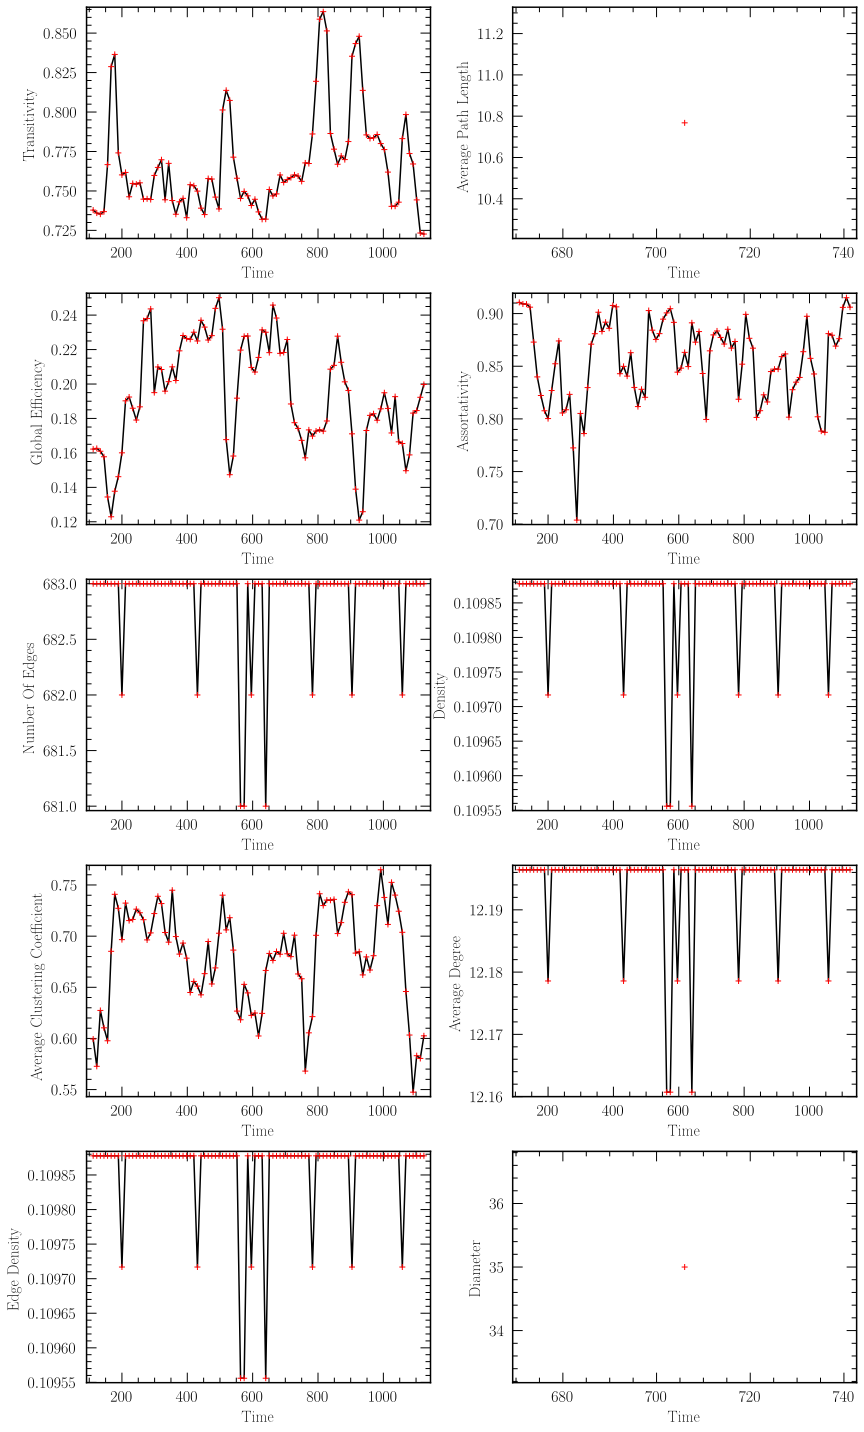

In [227]:
import matplotlib.pyplot as plt

# network_measures_df is a DataFrame with all the measures
measures = [
    'transitivity', 'average_path_length', 'global_efficiency', 'assortativity',
    'number_of_edges', 'density', 'average_clustering_coefficient', 'average_degree',
    'edge_density', 'diameter'
]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))
axes = axes.flatten() 
for ax, measure in zip(axes, measures):
    end_times = window_size + network_measures_df['window'].values * step_size
    ax.plot(end_times, network_measures_df[measure].values, color='k')
    ax.plot(end_times, network_measures_df[measure].values, marker="+", color='r', linestyle='')
    ax.set_xlabel('Time')
    ax.set_ylabel(measure.replace('_', ' ').title())  # Replace underscores with spaces and capitalize

plt.tight_layout()
plt.show()


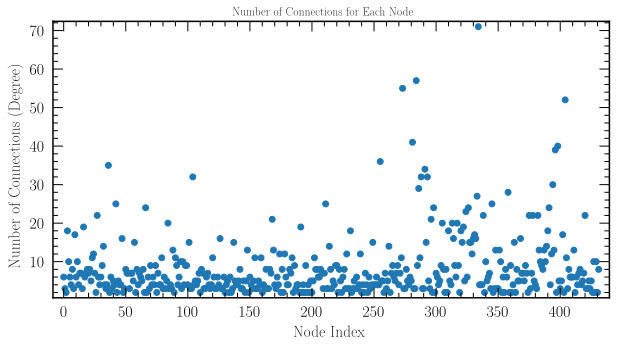

In [184]:

# degree_dict is dictionary of nodes (time points) and their degrees
degrees = [degree for node, degree in degree_dict.items()]

# Node indices
node_indices = list(range(len(degrees)))

# Plot
plt.scatter(node_indices, degrees)
plt.title('Number of Connections for Each Node')
plt.xlabel('Node Index')
plt.ylabel('Number of Connections (Degree)')
plt.show()



In [3]:
from pyunicorn.timeseries import RecurrencePlot

df = pd.read_csv('1ES_binned_lc.csv')
pred_df = pd.read_csv('1ES_pred_DHO_lc.csv')

rp = RecurrencePlot(df['scaled lumin'].values, metric='supremum', silence_level=2, local_recurrence_rate=0.1, tau=9, dim=5)
pred_rp = RecurrencePlot(pred_df['lumin'].values, metric='supremum', silence_level=2, local_recurrence_rate=0.1, tau=8, dim=6)
